In [1]:
# !pip install kaggle

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c platesv2
# !unzip platesv2.zip
# !unzip plates.zip

# !mv /content/plates/test /content/plates/unknown
# !mkdir /content/plates/test
# !mv /content/plates/unknown /content/plates/test/unknown

# import os
# import shutil

# def split_sample(src_folder, dst_folder_train, dst_folder_validation, validation_count, file_type='.jpg'):
#   os.makedirs(dst_folder_train)
#   os.makedirs(dst_folder_validation)

#   for dirs, folder, files in os.walk(src_folder):
#     images = list(filter(lambda file: file.endswith(file_type), files))
#     for i in range(len(images)):
#       if i < validation_count:
#         shutil.copyfile(src_folder + images[i], dst_folder_validation + images[i])
#       else:
#         shutil.copyfile(src_folder + images[i], dst_folder_train + images[i])


# split_sample('/content/plates/train/cleaned/', 
#              '/content/plates/modified/train/cleaned/', 
#              '/content/plates/modified/validation/cleaned/',
#              validation_count=4,
#              file_type='.jpg'
#              )

# split_sample('/content/plates/train/dirty/', 
#              '/content/plates/modified/train/dirty/', 
#              '/content/plates/modified/validation/dirty/',
#              validation_count=4,
#              file_type='.jpg'
#              )

train_sample_path = '/content/plates/modified/train/'
validation_sample_path = '/content/plates/modified/validation/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


print("TensorFlow verison:", tf.__version__)

TensorFlow verison: 2.8.2


In [14]:
seed = 42
batch_size=8

# Data Pipeline
def resize_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image, label

datagen_train = ImageDataGenerator(
        rotation_range=300,
        shear_range=0.2,
        zoom_range=0.4,
        channel_shift_range=255,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

datagen_validation = ImageDataGenerator()

ds_train_flow = datagen_train.flow_from_directory(
    directory=train_sample_path,
    shuffle=True,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    target_size=(224, 224))

ds_validation_flow = datagen_validation.flow_from_directory(
    directory=validation_sample_path,
    shuffle=True,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    target_size=(224, 224))

Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [15]:
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False
#base_model.summary()

In [18]:
model = keras.Sequential([
    keras.layers.Input(shape=(224,224,3), batch_size=batch_size),
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu', kernel_regularizer='l1'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=4,
    decay_rate=0.96,
    staircase=True)

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
  loss="binary_crossentropy",
  metrics=['accuracy'])

In [33]:
model.fit(
    ds_train_flow,
    validation_data=ds_validation_flow,
    epochs=50
  )

history = model.history

Epoch 1/50
4/4 [==============================] - 1s 327ms/step - loss: 2.1674 - accuracy: 0.6875 - val_loss: 2.0605 - val_accuracy: 0.8750
Epoch 2/50
4/4 [==============================] - 1s 270ms/step - loss: 2.1499 - accuracy: 0.7812 - val_loss: 2.0614 - val_accuracy: 0.8750
Epoch 3/50
4/4 [==============================] - 1s 285ms/step - loss: 1.9576 - accuracy: 0.8750 - val_loss: 2.0603 - val_accuracy: 0.8750
Epoch 4/50
4/4 [==============================] - 1s 295ms/step - loss: 2.1714 - accuracy: 0.7188 - val_loss: 2.0580 - val_accuracy: 0.8750
Epoch 5/50
4/4 [==============================] - 1s 299ms/step - loss: 2.1128 - accuracy: 0.7500 - val_loss: 2.0543 - val_accuracy: 0.8750
Epoch 6/50
4/4 [==============================] - 1s 144ms/step - loss: 2.0576 - accuracy: 0.9062 - val_loss: 2.0546 - val_accuracy: 0.8750
Epoch 7/50
4/4 [==============================] - 1s 149ms/step - loss: 2.0330 - accuracy: 0.8750 - val_loss: 2.0540 - val_accuracy: 0.8750
Epoch 8/50
4/4 [====

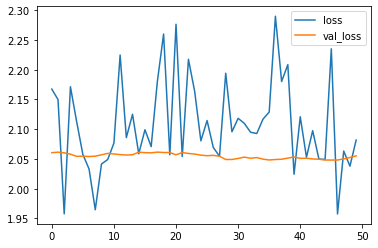

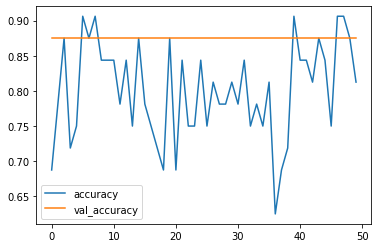

In [34]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [35]:
ds_test_ = keras.preprocessing.image_dataset_from_directory(
    "/content/plates/test/", 
    image_size=[256, 341],
    shuffle=False
)

ds_test = (
    ds_test_
    .map(resize_image)
    .cache()
)

prediction = model.predict(ds_test)

test_prediction = [prediction[i][0] for i in range(len(prediction))]
submission_df = pd.DataFrame.from_dict({'id': ds_test_.file_paths, 'label': test_prediction})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/plates/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)

submission_df.head(n=10)

submission_df.to_csv('submission.csv')

Found 744 files belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


In [31]:
ds_train_all_ = keras.preprocessing.image_dataset_from_directory(
    "/content/plates/train/", 
    image_size=[256, 341],
    shuffle=False
)

ds_train_all = (
    ds_train_all_
    .map(resize_image)
    .cache()
)

prediction_train_all = model.predict(ds_train_all)

train_prediction = [prediction_train_all[i][0] for i in range(len(prediction_train_all))]
submission_df = pd.DataFrame.from_dict({'id': ds_train_all_.file_paths, 'label': train_prediction})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/plates/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)

submission_df.head(n=40)

Found 40 files belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


,label
id,
/content/plates/train/cleaned/0000,cleaned
/content/plates/train/cleaned/0001,cleaned
/content/plates/train/cleaned/0002,cleaned
/content/plates/train/cleaned/0003,cleaned
/content/plates/train/cleaned/0004,cleaned
/content/plates/train/cleaned/0005,cleaned
/content/plates/train/cleaned/0006,cleaned
/content/plates/train/cleaned/0007,cleaned
/content/plates/train/cleaned/0008,cleaned
